# Meander Maker

If you haven't ever used the `googlemaps` python package, there are a few small setup steps to take first. You'll need to install it by running the next cell. Additionally, we will use `gmplot` to render the outputs and `polyline` to decode [Google's "Polyline"](https://developers.google.com/maps/documentation/utilities/polylineutility) hash. Finally, generate an API key to interface with Google's services. (There is a free tier, but if you use it a lot, they will start charging you for access.)

In [ ]:
!pip install googlemaps
!pip install gmplot
!pip install polyline
!pip install haversine

In [ ]:
!conda install -c conda-forge hdbscan

As mentioned above, if you would like to tinker around with the code, you'll need your own API key for Google Maps. You can register one from this address: [https://developers.google.com/places/web-service/get-api-key](https://developers.google.com/places/web-service/get-api-key). Once you have one, create a file in the directory containing this notebook called `.secret.key` and simply paste in your newly generated API key, no quotes or line breaks or anything. Save the file, exit, and you should be good to go.

In [ ]:
import goplaces as gp

%load_ext autoreload
%autoreload 2

Let's decide which topic to explore:

In [15]:
loc, topic = gp.populate_inputs()

Where would you like to start? Woodinville, WA
What theme would you like to explore today? wine tasting


{'C': 1.8874, 'A': 0.5622, 'B': 2.6577, 'D': 14.337}

,lat,lng,name,rating,user_ratings_total,label,dist_to_loc
19,47.766128,-122.148302,Gard Vintners Woodinville Wine Tasting Room,4.9,14,C,1738.819266
20,47.766175,-122.148329,Beaumont Cellars,4.9,21,C,1741.475632
21,47.762251,-122.150158,Icon Cellars,5.0,24,C,1333.070663
22,47.762653,-122.149388,DiStefano Winery Ltd,4.3,13,C,1405.739666
23,47.763553,-122.149258,Keira Cellars,4.8,20,C,1480.991538
24,47.762285,-122.149928,Barrel Wine Tours,0.0,0,C,1348.457721


,lat,lng,name,rating,user_ratings_total,label,dist_to_loc
0,47.731705,-122.155311,JM Cellars,4.7,78,A,2581.427654
1,47.734995,-122.152983,Novelty Hill Januik Winery,4.4,109,A,2281.379804
2,47.737264,-122.155920,Cascade Cliffs Vineyard and Winery - Woodinvil...,4.9,17,A,1972.670730
3,47.740026,-122.154697,The Woodhouse Wine Estates,4.8,51,A,1713.465554
4,47.729804,-122.149313,Chateau Ste. Michelle Winery,4.5,1075,A,2918.321228
5,47.737260,-122.156079,Basel Cellars Woodinville,4.6,44,A,1969.733950
6,47.733874,-122.151987,Columbia Winery,4.6,160,A,2424.231015


,lat,lng,name,rating,user_ratings_total,label,dist_to_loc
7,47.733658,-122.142590,Obelisco Estate,4.6,15,B,2772.233408
8,47.732020,-122.141998,Sparkman Cellars Tasting Room,4.7,13,B,2948.446257
9,47.733969,-122.141733,J. Bookwalter Tasting Studio,4.6,41,B,2780.667645
10,47.733085,-122.142579,Patterson Cellars Tasting Room Hollywood Hill,4.5,51,B,2825.581903
11,47.733092,-122.142428,Gorman Winery Hollywood Hill Tasting Room,4.5,28,B,2831.192531
12,47.732142,-122.142161,Mark Ryan Winery,4.5,52,B,2930.436685
13,47.732613,-122.140887,Milbrandt Vineyards Tasting Room,4.8,14,B,2940.176971
14,47.732506,-122.140939,Ryan Patrick Wines Tasting Room,4.0,17,B,2947.776936
15,47.734491,-122.141790,Woodinville Wine Country,4.6,8,B,2731.223827
16,47.733966,-122.141354,Market Vineyards,4.9,8,B,2797.581413


,lat,lng,name,rating,user_ratings_total,label,dist_to_loc
25,47.768751,-122.150770,Obelisco Warehouse Tasting Room,5.0,7,D,1869.192292
26,47.769470,-122.151267,Patterson Cellars Tasting Room Warehouse District,4.6,24,D,1920.681416
27,47.769324,-122.150587,Genoa Cellars Tasting Room - WE MOVED from our...,4.6,11,D,1931.180299
28,47.769324,-122.150587,Rocky Pond Winery Woodinville Tasting Room,4.7,15,D,1931.218863
29,47.769152,-122.150960,Eye of the Needle Winery,4.7,21,D,1900.736615
30,47.768706,-122.150868,Smasne Cellars,4.9,11,D,1861.229321
31,47.769478,-122.150242,Gorman Winery's Old Scratch Cellars Tasting Room,3.8,12,D,1958.923092
32,47.769164,-122.150307,Kestrel Vintners,4.7,35,D,1926.370627
33,47.769200,-122.150448,Genoa Cellars Tasting Room - Woodinville Wareh...,5.0,1,D,1924.451902


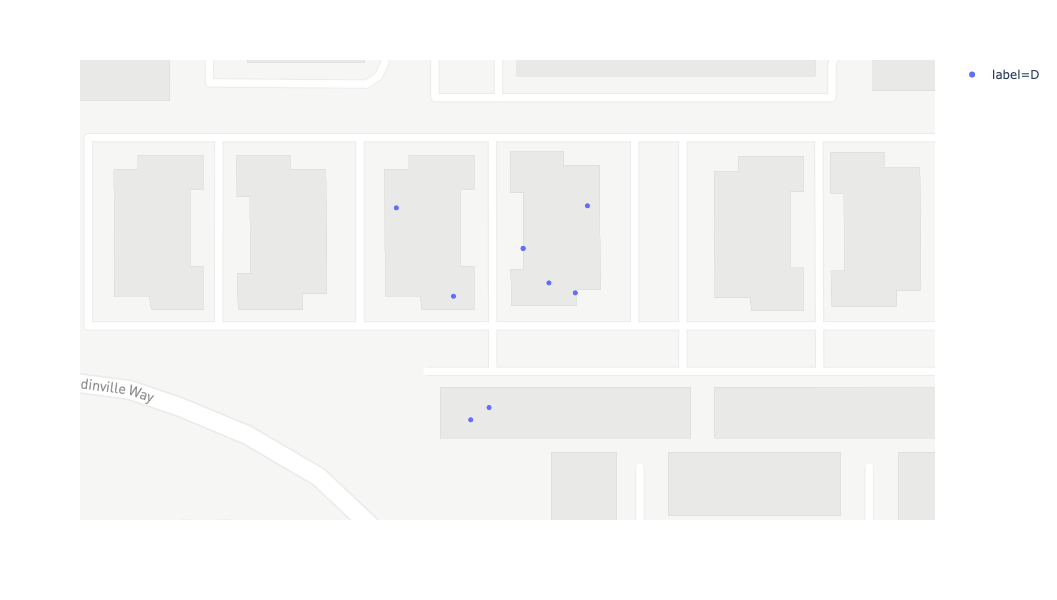

In [18]:
df = gp.build_df(loc, topic)
best_cluster = gp.choose_cluster(df, loc, verbose=True)
gp.mapbox(best_cluster)

In [11]:
wlk = gp.meander(best_cluster, loc, mode='walking', verbose=True)
gp.html_builder(loc, wlk, tab=True)

+719 m --and-- +9.97 min
+230 m --and-- +3.15 min
+107 m --and-- +1.57 min
+276 m --and-- +4.22 min
+133 m --and-- +2.12 min
+82 m --and-- +1.18 min
+268 m --and-- +3.13 min
+318 m --and-- +3.77 min
+62 m --and-- +0.88 min
total dist: 2195 m 
est time: 30.0 min


.  
---------TESTING---------TESTING---------TESTING---------TESTING---------TESTING---------  
.  